# Multi-Class Classification 1D CNN

1D CNN with multi-class classification.

We are going to see if we can create a 1D CNN that can classify an individual as a healthy control or as a subject diagnosed with one of 3 neuropsychiatric disorders, based on the shape (LB spectrum) of their white matter tracts.

The data set we will use contains individuals that have been diagnosed with bipolar disorder, ADHD, and schizophrenia.

### Import the needed libraries

In [1]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1, l2, l1_l2
#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import the data

In [2]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
allgroups_ev_dict = pickle.load(open("allgroups_ev_dict.p",'rb'))
# list of tracts we want to use
all_tracts = pickle.load(open('all_tracts.p','rb'))
# subject list
allsubjs = pickle.load(open('allsubjs.p','rb'))
# list of subject group 0 = control, 1 = adhd, 2 = bipolar, 3 = schizophrenia
groupid = pickle.load(open('groupid.p','rb'))

Since we examined the data in the last notebook we will not do that here.

As a reminder: We have 158 subject in total. We have around 40 samples (individuals) in each group. The original dataset of the control group had over 100, we have randomly chosen 40 to keep the group sizes similar. 0 is controls - 40, 1 is ADHD - 37, 2 is bipolar -43, and 3 is schizophrenia - 38.

## Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single vector per subject.

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's StandardScaler function.

### Normalize the data

In [3]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict

In [4]:
# normalize all of the tracts so that each ev is centered on 0.
allgroups_ev_dict_scaled = scale_ev_dict(allgroups_ev_dict)

### Reorganize the data

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape (158, n * 20), where 158 is the number of subjects and n is the number of eigenvalues we are using. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary. We will start with just 200 eigenvalues for all tracts.

In [5]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=allsubjs, tractstouse=all_tracts):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled

In [6]:
allgroups_ev_dict_scaled_alltracts_2d = reorganize_spectrums(allgroups_ev_dict_scaled, 200)

In [7]:
allgroups_ev_dict_scaled_alltracts_2d.shape

(158, 4000)

### Reshape the data for CNN layers

We need to change the shape again to be a 3D array instead of a 2D array. We need each subject to have their own 2D array. The final shape will be (num subjects, num total eigenvalues, 1).

If this were a sequence it would be (num samples, num timestamps, num features per timestamp). I find it helps with understanding the shape if you think about the data in terms of timestamps, even though it is not sequential data.

Another way we could format the data is by splitting each tract into its own feature, rather than combining them all into one. In that case, the shape would be (num subjects, num eigenvalues per tract, num tracts). Each tract is a feature, and each eigenvalue is a timestamp.

In [8]:
allgroups_ev_dict_scaled_alltracts = allgroups_ev_dict_scaled_alltracts_2d.reshape(allgroups_ev_dict_scaled_alltracts_2d.shape[0], allgroups_ev_dict_scaled_alltracts_2d.shape[1], 1)
print allgroups_ev_dict_scaled_alltracts.shape

(158, 4000, 1)


### One-hot encode the labels

Right now the labels are integers, we need to change them so they are one-hot encoded. This time we will use Keras bult-in function.

In [9]:
groupid_one = to_categorical(groupid)

### Check datatype

In [10]:
groupid_one = groupid_one.astype('float32')
allgroups_ev_dict_scaled_alltracts = allgroups_ev_dict_scaled_alltracts.astype('float32')

### Split the dataset

This is a very small dataset, so it will likely not do well if we split the data into the three training/validation/testing sets. Since the dataset is so small, this is just an initial test, and we are not even sure if a neural network will work, we are going to just split the data into two sets, a training set and a testing set.

In [11]:
X = allgroups_ev_dict_scaled_alltracts
Y = groupid_one

#first split the training/validation data from the testing data
trainX, testX, trainY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainX) 
print len(testX)

126
32


In [12]:
#print the sum of each column in the one hot encoded labels
np.sum(testY, axis=0)

array([7., 9., 8., 8.], dtype=float32)

It is important to note that the train_test_split function will shuffle the data for you. In the testing dataset we have a fairly even distribution of classes.

We now have a training set and a testing set of data and we are ready to try classification with a 1D CNN. Given that we have 4 categories of labels and roughly even amounts of samples for each label, by chance we should get ~25% correct. Our goal is to get a classification accuracy higher than chance.

We learned with the MLP that adding weights to the categories helped with classification. Let's compute the weights now.

### Compute the class weights

In [13]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in trainY]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(class_weights)

[0.95454545 1.125      0.9        1.05      ]


## Set up the 1D CNN

We are going to try a basic 1D CNN. This will be the same model architecture we started with for the binary 1D CNN, however, the last Dense layer will have 4 nodes (1 per category) and use the softmax activation function. We will also use the categorical_crossentropy loss function.

In [14]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 3s 24ms/step - loss: 1.3921 - acc: 0.2302 - val_loss: 1.3874 - val_acc: 0.2188
Epoch 2/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3829 - acc: 0.2698 - val_loss: 1.3900 - val_acc: 0.2500
Epoch 3/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3855 - acc: 0.2619 - val_loss: 1.3900 - val_acc: 0.2500
Epoch 4/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3845 - acc: 0.2778 - val_loss: 1.3897 - val_acc: 0.2188
Epoch 5/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3783 - acc: 0.3254 - val_loss: 1.3814 - val_acc: 0.2813
Epoch 6/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3875 - acc: 0.2937 - val_loss: 1.3802 - val_acc: 0.2813
Epoch 7/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3633 - acc: 0.3571 - val_loss: 1.3742 - val_acc: 0.3125
Epoch 8/20
126/126 [==========

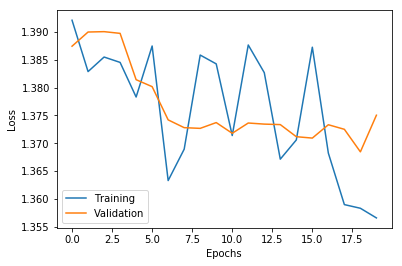

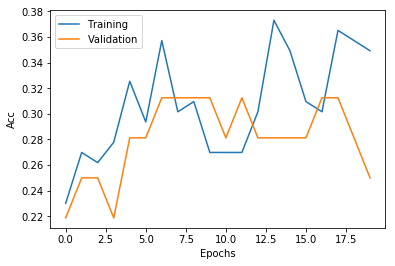

In [113]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_data=(testX, testY), class_weight=class_weights)

plot_history(history)


Ok, right away we are not doing much better than chance. Let's try changing some of the parameters and removing the global pooling layer as that has helped in the past.

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 3s 25ms/step - loss: 1.4737 - acc: 0.2778 - val_loss: 1.3812 - val_acc: 0.2500
Epoch 2/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3696 - acc: 0.3492 - val_loss: 1.3754 - val_acc: 0.2500
Epoch 3/20
126/126 [==============================] - 0s 2ms/step - loss: 1.2207 - acc: 0.5079 - val_loss: 1.4255 - val_acc: 0.2188
Epoch 4/20
126/126 [==============================] - 0s 2ms/step - loss: 1.0277 - acc: 0.5238 - val_loss: 1.5201 - val_acc: 0.2813
Epoch 5/20
126/126 [==============================] - 0s 2ms/step - loss: 0.8057 - acc: 0.7143 - val_loss: 2.0220 - val_acc: 0.2813
Epoch 6/20
126/126 [==============================] - 0s 2ms/step - loss: 0.6876 - acc: 0.7302 - val_loss: 2.0322 - val_acc: 0.2500
Epoch 7/20
126/126 [==============================] - 0s 2ms/step - loss: 0.4055 - acc: 0.8730 - val_loss: 2.3695 - val_acc: 0.3438
Epoch 8/20
126/126 [==========

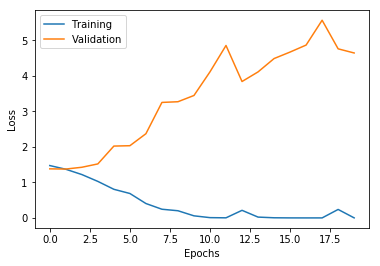

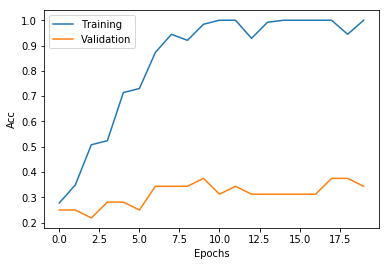

In [114]:
model = Sequential()
model.add(Conv1D(100, 3, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Conv1D(100, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(100, 3, activation='relu'))
model.add(Conv1D(100, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
# model.add(GlobalAveragePooling1D())
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_data=(testX, testY), class_weight=class_weights)

plot_history(history)


Ok, we reached 37% accuracy, but the model is very overfit. Let's add in regularization and keep trying other parameters.

In [115]:
# hidden_units = 64
# kernel_size = 3
# dropout = .5
# optim = 'adam'
# epochs = 20
# batch = 10
# reg=l1(0.01)

def make_model(hidden_units, kernel_size, dropout, optim, epochs, batch, reg):
    model = Sequential()
    model.add(Conv1D(hidden_units, kernel_size, activation='tanh', input_shape=(trainX.shape[1], 1), kernel_regularizer=reg))
    model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
    model.add(MaxPooling1D(kernel_size))
    model.add(Dropout(dropout))
    model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
    model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
    model.add(MaxPooling1D(kernel_size))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(testX, testY), class_weight=class_weights)

    plot_history(history)
    return model

Train on 126 samples, validate on 32 samples
Epoch 1/10
126/126 [==============================] - 5s 38ms/step - loss: 2.3452 - acc: 0.2937 - val_loss: 2.1270 - val_acc: 0.2812
Epoch 2/10
126/126 [==============================] - 1s 8ms/step - loss: 2.0704 - acc: 0.3730 - val_loss: 1.7819 - val_acc: 0.2500
Epoch 3/10
126/126 [==============================] - 1s 7ms/step - loss: 1.7931 - acc: 0.3810 - val_loss: 2.4418 - val_acc: 0.2500
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 1.2455 - acc: 0.6349 - val_loss: 2.9807 - val_acc: 0.3438
Epoch 5/10
126/126 [==============================] - 1s 7ms/step - loss: 0.5856 - acc: 0.8810 - val_loss: 3.0942 - val_acc: 0.2500
Epoch 6/10
126/126 [==============================] - 1s 7ms/step - loss: 0.3132 - acc: 0.9841 - val_loss: 3.5729 - val_acc: 0.2500
Epoch 7/10
126/126 [==============================] - 1s 7ms/step - loss: 0.2670 - acc: 0.9841 - val_loss: 4.0462 - val_acc: 0.2812
Epoch 8/10
126/126 [==========

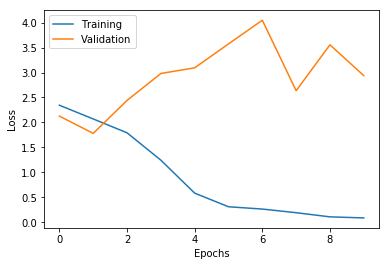

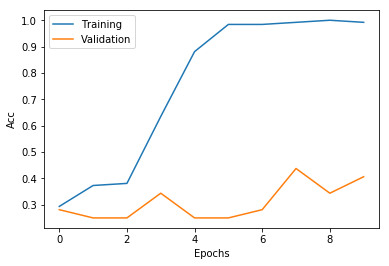

In [116]:
hidden_units = 100
kernel_size = 3
dropout = .3
optim = RMSprop(lr=0.001)
epochs = 10
batch = 1
reg=l2(0.001)

model = make_model(hidden_units, kernel_size, dropout, optim, epochs, batch, reg)

After trying a few parameter combinations, we reached 43% accuracy, however the model is still overfitting. Let's take a look at how the data is being represented by the model.

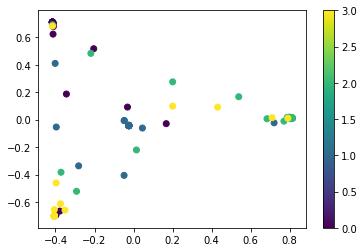

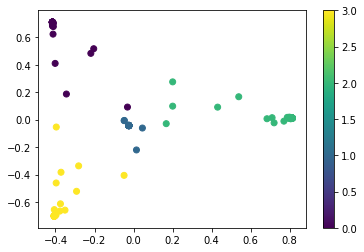

In [117]:
pred = model.predict(allgroups_ev_dict_scaled_alltracts)
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))
pca = PCA(n_components=2)
pts = pca.fit_transform(pred)
plt.scatter(pts[:,0], pts[:,1], c = groupid)
plt.colorbar()
plt.show()

plt.scatter(pts[:,0], pts[:,1], c = pred_class)
plt.colorbar()
plt.show()

It is creating clear boundaries for the four groups, but the boundaries are not very accurate. 

(array([41.,  0.,  0., 32.,  0.,  0., 44.,  0.,  0., 41.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

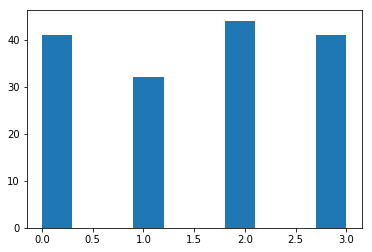

In [118]:
plt.hist(pred_class)

The distribution of the predictions of all of the subjects is well spread out, however, which is good. The model is not just predicting one or two classes.

Let's add back in the global pooling layer. With that layer the model was much less overfit. Let's also save down the best model at take a look at how the best model represents the data.

In [15]:
from keras.callbacks import ModelCheckpoint

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 3s 26ms/step - loss: 1.3971 - acc: 0.2778 - val_loss: 1.3876 - val_acc: 0.2188
Epoch 2/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3944 - acc: 0.2063 - val_loss: 1.3816 - val_acc: 0.2813
Epoch 3/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3819 - acc: 0.3016 - val_loss: 1.3748 - val_acc: 0.2500
Epoch 4/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3764 - acc: 0.3254 - val_loss: 1.3772 - val_acc: 0.2813
Epoch 5/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3932 - acc: 0.2778 - val_loss: 1.3769 - val_acc: 0.2813
Epoch 6/20
126/126 [==============================] - 0s 1ms/step - loss: 1.3851 - acc: 0.2698 - val_loss: 1.3763 - val_acc: 0.2500
Epoch 7/20
126/126 [==============================] - 0s 2ms/step - loss: 1.3847 - acc: 0.2857 - val_loss: 1.3790 - val_acc: 0.2813
Epoch 8/20
126/126 [==========

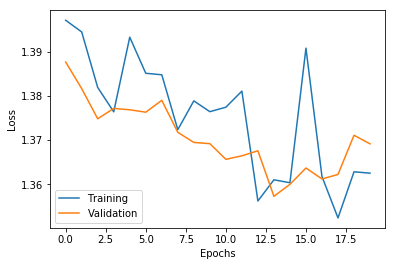

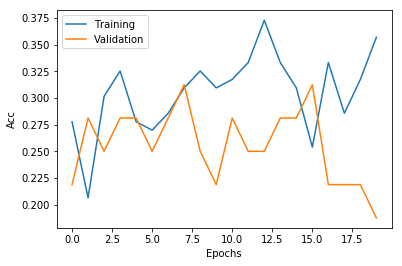

In [119]:
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_MC_1dcnn1.h5', monitor='val_acc', save_best_only=True)


model = Sequential()
model.add(Conv1D(100, 3, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Conv1D(100, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(100, 3, activation='relu'))
model.add(Conv1D(100, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Flatten())
model.add(GlobalAveragePooling1D())
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=10, validation_data=(testX, testY), callbacks=[best_model], class_weight=class_weights)

plot_history(history)


In [16]:
# load in the best model we saved down during training using the callback function
from keras.models import load_model
best_model1 = load_model('bestmodel_MC_1dcnn1.h5')
score = best_model1.evaluate(testX, testY)
print score

32/32 [==============================] - 1s 20ms/step
[1.371769666671753, 0.3125]


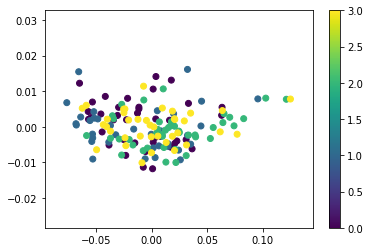

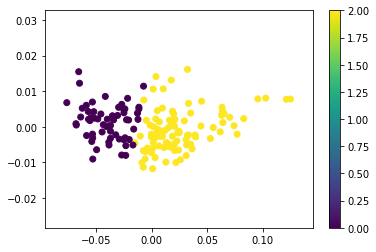

(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 98.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

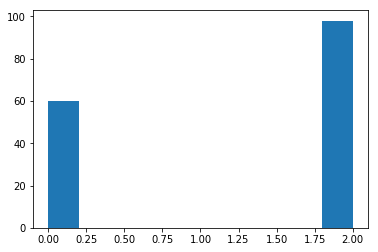

In [124]:
pred = best_model1.predict(allgroups_ev_dict_scaled_alltracts)
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))
pca = PCA(n_components=2)
pts = pca.fit_transform(pred)
plt.scatter(pts[:,0], pts[:,1], c = groupid)
plt.colorbar()
plt.show()

plt.scatter(pts[:,0], pts[:,1], c = pred_class)
plt.colorbar()
plt.show()

plt.hist(pred_class)

While the global layer prevents the model from becoming too overfit, the model only learns/predicts two of the categories, even with the class weights.

Train on 126 samples, validate on 32 samples
Epoch 1/10
126/126 [==============================] - 4s 33ms/step - loss: 2.3577 - acc: 0.2619 - val_loss: 1.7745 - val_acc: 0.3125
Epoch 2/10
126/126 [==============================] - 1s 8ms/step - loss: 2.0341 - acc: 0.2698 - val_loss: 1.8647 - val_acc: 0.3125
Epoch 3/10
126/126 [==============================] - 1s 7ms/step - loss: 1.6898 - acc: 0.5079 - val_loss: 1.9595 - val_acc: 0.2188
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 1.0101 - acc: 0.7381 - val_loss: 2.6077 - val_acc: 0.4062
Epoch 5/10
126/126 [==============================] - 1s 7ms/step - loss: 0.4927 - acc: 0.9127 - val_loss: 3.3281 - val_acc: 0.3438
Epoch 6/10
126/126 [==============================] - 1s 7ms/step - loss: 0.2597 - acc: 0.9921 - val_loss: 3.8713 - val_acc: 0.3438
Epoch 7/10
126/126 [==============================] - 1s 8ms/step - loss: 0.1745 - acc: 0.9921 - val_loss: 4.6215 - val_acc: 0.2812
Epoch 8/10
126/126 [==========

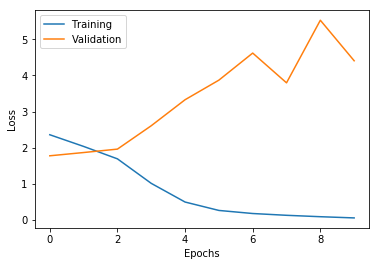

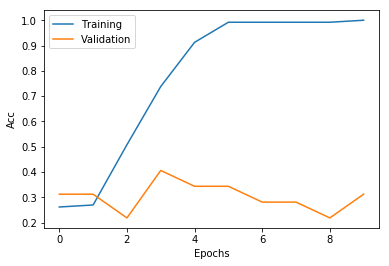

In [125]:
hidden_units = 100
kernel_size = 3
dropout = .3
optim = RMSprop(lr=0.001)
epochs = 10
batch = 1
reg=l2(0.001)
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_MC_1dcnn2.h5', monitor='val_acc', save_best_only=True)

model = Sequential()
model.add(Conv1D(hidden_units, kernel_size, activation='tanh', input_shape=(trainX.shape[1], 1), kernel_regularizer=reg))
model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
model.add(MaxPooling1D(kernel_size))
model.add(Dropout(dropout))
model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
model.add(Conv1D(hidden_units, kernel_size, activation='tanh', kernel_regularizer=reg))
model.add(MaxPooling1D(kernel_size))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(testX, testY), class_weight=class_weights, callbacks=[best_model])

plot_history(history)

In [17]:
best_model2 = load_model('bestmodel_MC_1dcnn2.h5')
score = best_model2.evaluate(testX, testY)
print score

32/32 [==============================] - 0s 3ms/step
[2.6076598167419434, 0.40625]


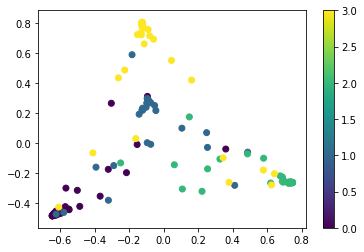

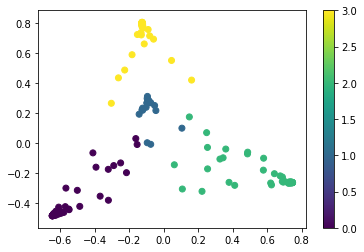

(array([46.,  0.,  0., 28.,  0.,  0., 52.,  0.,  0., 32.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

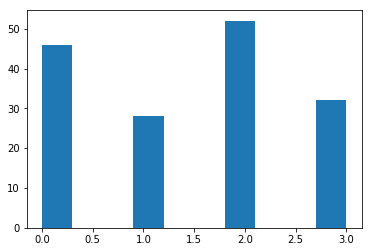

In [18]:
pred = best_model2.predict(allgroups_ev_dict_scaled_alltracts)
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))
pca = PCA(n_components=2)
pts = pca.fit_transform(pred)
plt.scatter(pts[:,0], pts[:,1], c = groupid)
plt.colorbar()
plt.show()

plt.scatter(pts[:,0], pts[:,1], c = pred_class)
plt.colorbar()
plt.show()

plt.hist(pred_class)

We were able to reach 40% correct and we can see that the prediction class plot is starting to look more like the actual class plot.

Lets look at the predictions of the test data and see the distribution there.

In [19]:
testpred = best_model2.predict(testX)
predicted_ints = [y.argmax() for y in testpred]
print predicted_ints
testy_ints = [y.argmax() for y in testY]
print testy_ints

correct = [0,0,0,0]
for i in range(len(testY)):
    if testy_ints[i] == predicted_ints[i]:
        correct[testy_ints[i]] += 1

print correct
print np.sum(testY, axis=0)

[0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 3, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 3, 2, 0, 0, 2, 3, 2]
[0, 1, 2, 3, 1, 3, 3, 3, 2, 2, 0, 3, 0, 1, 2, 2, 3, 2, 3, 1, 1, 0, 1, 0, 1, 0, 2, 0, 3, 2, 1, 1]
[4, 1, 7, 1]
[7. 9. 8. 8.]


We can see that the model correctly predicts 4/7 controls, 1/9 adhd subjects, 7/8 bipolar subjects, and 1/8 schizophrenic subjects. There is definitely a bias towards the control and bipolar subjects. It seems that the class weighting does not do as well with CNNs as it does with the MLP.

## Final Comments

The goal was to build a multi-class 1D CNN that could classify individuals as a control or one of three neuropsychiatric disorders based on the shape of their white matter tracts (via the LB spectrum).

This goal was met. I was able to build a 1D CNN that classified higher than chance overall. It did not classify higher than chance for all categories, however and did very poorly with two of the classes.

The final model was best at predicting new bipolar subjects, followed by control subjects. The model did the worst with ADHD and schizophrenic subjects. Even with the class weights it seems that the CNN is affected by the small imbalance in the dataset. 
